In [7]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generator loaded with trained weights.


Saving test.jpg to test (2).jpg
Uploaded file: test (2).jpg
Super-resolved image saved at: /content/SRGAN_test_results/SR_test (2).jpg


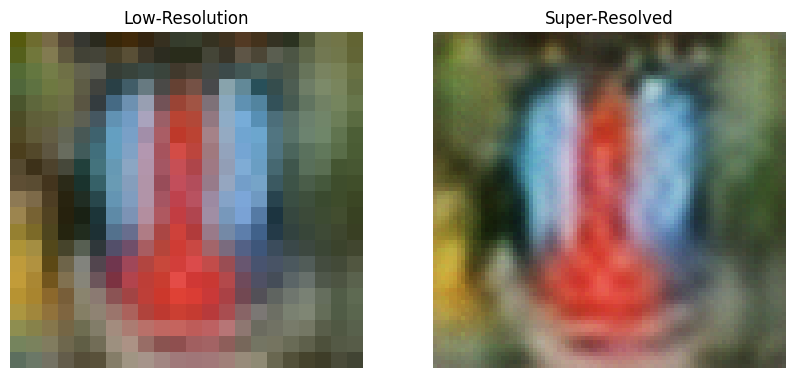

In [8]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
from torchvision.utils import save_image
from torchvision import transforms
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
import os
import math

# -----------------------------
# Settings
# -----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = '/content/SRGAN_test_results'
os.makedirs(SAVE_DIR, exist_ok=True)
from google.colab import drive
drive.mount('/content/drive')

MODEL_PATH = '/content/drive/MyDrive/SRGAN_results/netG_final.pth'  # path to your trained generator

# -----------------------------
# Define Generator (use same architecture as training)
# -----------------------------
# Example: simple SRGAN generator class, replace with your trained model definition
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual
class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2


# Initialize and load weights
netG = Generator(UPSCALE_FACTOR).to(DEVICE)
netG.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
netG.eval()
print("Generator loaded with trained weights.")

# -----------------------------
# Image preprocessing
# -----------------------------
def preprocess_image(img):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

# -----------------------------
# Upload LR Image
# -----------------------------
uploaded = files.upload()
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')

    lr_image = Image.open(filename).convert('RGB')
    lr_tensor = preprocess_image(lr_image).to(DEVICE)

    # Generate SR image
    with torch.no_grad():
        sr_tensor = netG(lr_tensor)

    # Save SR image
    save_path = os.path.join(SAVE_DIR, 'SR_' + filename)
    save_image(sr_tensor, save_path, normalize=True)
    print(f'Super-resolved image saved at: {save_path}')

    # Display LR and SR side by side
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(lr_image)
    plt.title('Low-Resolution')
    plt.axis('off')

    plt.subplot(1,2,2)
    sr_image = transforms.ToPILImage()(sr_tensor.squeeze(0).cpu())
    plt.imshow(sr_image)
    plt.title('Super-Resolved')
    plt.axis('off')
    plt.show()

In [4]:
import torch
import torch.nn as nn

class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        # Learned upsampling via PixelShuffle
        self.conv = nn.Conv2d(in_channels, in_channels * (up_scale ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x=self.conv(x)
        x=self.prelu(x)
        return self.pixel_shuffle(x)

        return self.prelu(self.pixel_shuffle(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x) # Skip connection for gradient flow

class SuperResolutionCNN(nn.Module):
    def __init__(self):
        super(SuperResolutionCNN, self).__init__()

        # Layer 1: Initial Feature Extraction
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # 3x3 better for small 22x22
        self.prelu = nn.PReLU()

        # Layers 2-13: Deep Residual Mapping (6 blocks * 2 layers each)
        res_layers = [ResidualBlock(64) for _ in range(6)]
        self.res_blocks = nn.Sequential(*res_layers)

        # Layer 14: Upsampling Stage (22x22 -> 44x44 -> 88x88)
        self.upsample = nn.Sequential(
            UpsampleBLock(64, 2),
            UpsampleBLock(64, 2)
        )

        # Layer 15: Final Reconstruction
        self.conv_final = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        f1 = self.prelu(self.conv1(x))
        res = self.res_blocks(f1)
        up = self.upsample(f1 + res) # Global residual learning
        return self.conv_final(up)

Mounted at /content/drive_new
✅ Model loaded successfully from Google Drive!

Please upload the image you want to upscale:


Saving test.jpg to test (1).jpg


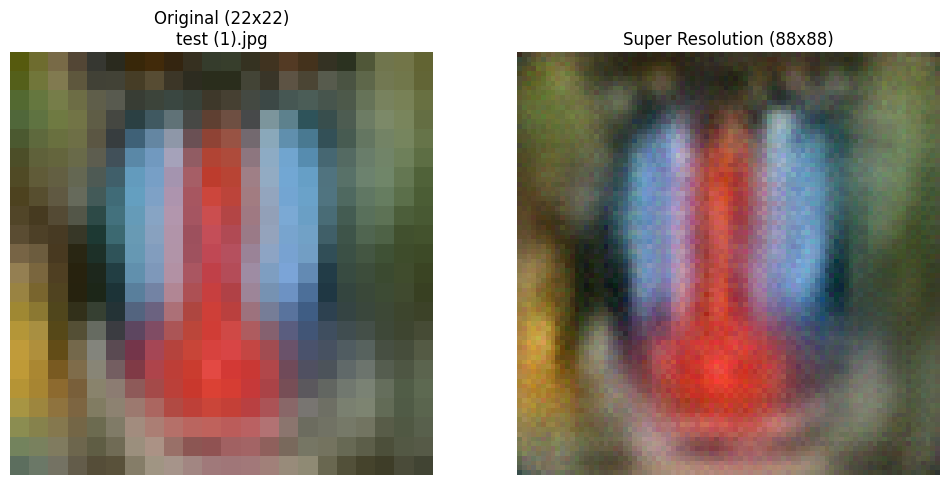

✨ Upscaled image saved to: /content/drive_new/MyDrive/SR_CNN_Results/upscaled_test (1).jpg


In [5]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
from google.colab import files, drive  # Added drive for mounting
import matplotlib.pyplot as plt
import os

# --- 1. Mount Google Drive ---
# This is required to access your .pth file
if not os.path.exists('/content/drive_new'):
    drive.mount('/content/drive_new')

# --- 2. Load the Model Architecture ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the SuperResolutionCNN class is defined in this notebook!
model = SuperResolutionCNN().to(device)
model_path = '/content/drive_new/MyDrive/SR_CNN_Results/cnn_final_weights.pth'

if os.path.exists(model_path):
    # Use weights_only=True for security if using newer torch versions
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("✅ Model loaded successfully from Google Drive!")
else:
    print(f"❌ Error: Model file not found at {model_path}")
    print("Double check your folder names in Google Drive.")

# --- 3. Upload and Process Image ---
print("\nPlease upload the image you want to upscale:")
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert('RGB')

    # Preprocess: Resize to 22x22 and convert to Tensor (0-1 range)
    transform = transforms.Compose([
        transforms.Resize((22, 22)),
        transforms.ToTensor(),
    ])

    lr_tensor = transform(img).unsqueeze(0).to(device)

    # --- 4. Run Inference ---
    with torch.no_grad():
        sr_tensor = model(lr_tensor)
        sr_tensor = torch.clamp(sr_tensor, 0, 1)

    # --- 5. Display and Save Results ---
    lr_display = lr_tensor.squeeze(0).cpu().permute(1, 2, 0)
    sr_display = sr_tensor.squeeze(0).cpu().permute(1, 2, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(lr_display)
    plt.title(f"Original (22x22)\n{filename}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(sr_display)
    plt.title("Super Resolution (88x88)")
    plt.axis('off')
    plt.show()

    # Optional: Save the output back to your drive
    output_img = transforms.ToPILImage()(sr_tensor.squeeze(0).cpu())
    save_path = f'/content/drive_new/MyDrive/SR_CNN_Results/upscaled_{filename}'
    output_img.save(save_path)
    print(f"✨ Upscaled image saved to: {save_path}")